<a href="https://colab.research.google.com/github/ABCutter/Cohort-18-Projects/blob/main/Project4_Spotify_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 4: Music Popularity Prediction


This project will take data features collected for songs that have been on the Top 200 Weekly (Global) charts of Spotify in 2020 & 2021. The popularity of the song will be predicted using a tree-based regression model trained on these features.



The goals for the project are:

- Minimize the cross-validated ***root mean squared error ( RMSE )*** when predicting the popularity of a new song.

- Determine the importance of the features in driving the regression result.
The project will be done using tree-based regression techniques as covered in class. The hyperparameters of the trees should be carefully selected to avoid over-fitting.


There are three main challenges for this project:

1. Determining the outcome ( i.e. target ).  There is a "popularity" column.  But other columns may or may not be more appropriate indicators of popularity.

1. Choosing appropriate predictors ( i.e. features ). When building a machine learning model, we want to make sure that we consider how the model will be ultimately used. For this project, we are predicting the popularity of a new song. Therefore, we should only include the predictors we would have for a new song. It might help to imagine that the song will not be released for several weeks.

1. Data cleaning and feature engineering. Some creative cleaning and/or feature engineering may be needed to extract useful information for prediction.



Once again, be sure to go through the whole data science process and document as such in your Jupyter notebook.

The data is available AWS at https://ddc-datascience.s3.amazonaws.com/Projects/Project.4-Spotify/Data/Spotify.csv .



##Installs

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import ast
from sklearn.preprocessing import MultiLabelBinarizer

import pickle

import xgboost as xgb
from sklearn.model_selection import GridSearchCV

from wordcloud import WordCloud
from collections import Counter
import re

##Data Collection/Sources

In [2]:
#Curl command to collect and store data
url = "https://ddc-datascience.s3.amazonaws.com/Projects/Project.4-Spotify/Data/Spotify.csv"
!curl -s -I {url}

HTTP/1.1 200 OK
x-amz-id-2: qUfJh7hjUbWVqlUwoVou4D4Z5aGhIvU6bZVg0zbMgacTS+sZTX1QcxLZ+KZf0ntLDFDVR2QkkXUjE0VBmSAZXo5PdWkqspLabmlpGJcYHFs=
x-amz-request-id: 2EK28HQZ690CTEMK
Date: Thu, 07 Aug 2025 15:03:10 GMT
Last-Modified: Wed, 04 Oct 2023 17:23:56 GMT
ETag: "65b9875b11e0d7ea03ee2af024f45e99"
x-amz-server-side-encryption: AES256
Accept-Ranges: bytes
Content-Type: text/csv
Content-Length: 738124
Server: AmazonS3



In [3]:
!curl -s -O {url}

In [4]:
ls -la

total 740
drwxr-xr-x 1 root root   4096 Aug  7 15:03 ./
drwxr-xr-x 1 root root   4096 Aug  7 15:02 ../
drwxr-xr-x 4 root root   4096 Aug  5 17:21 .config/
drwxr-xr-x 1 root root   4096 Aug  5 17:22 sample_data/
-rw-r--r-- 1 root root 738124 Aug  7 15:03 Spotify.csv


In [5]:
!head -1 Spotify.csv | tr , '\n' | cat -n

     1	Index
     2	Highest Charting Position
     3	Number of Times Charted
     4	Week of Highest Charting
     5	Song Name
     6	Streams
     7	Artist
     8	Artist Followers
     9	Song ID
    10	Genre
    11	Release Date
    12	Weeks Charted
    13	Popularity
    14	Danceability
    15	Energy
    16	Loudness
    17	Speechiness
    18	Acousticness
    19	Liveness
    20	Tempo
    21	Duration (ms)
    22	Valence
    23	Chord


In [6]:
url = 'https://ddc-datascience.s3.amazonaws.com/Projects/Project.4-Spotify/Data/Spotify.csv'

In [7]:
df = pd.read_csv(url)

###Spotify Data Dictionary
https://developer.spotify.com/documentation/web-api/reference/get-audio-features

In [8]:
df.shape

(1556, 23)

In [9]:
df.head()

,Index,Highest Charting Position,Number of Times Charted,Week of Highest Charting,Song Name,Streams,Artist,Artist Followers,Song ID,Genre,...,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,Chord
0,1,1,8,2021-07-23--2021-07-30,Beggin',"48,633,449",Måneskin,3377762,3Wrjm47oTz2sjIgck11l5e,"['indie rock italiano', 'italian pop']",...,0.714,0.8,-4.808,0.0504,0.127,0.359,134.002,211560,0.589,B
1,2,2,3,2021-07-23--2021-07-30,STAY (with Justin Bieber),"47,248,719",The Kid LAROI,2230022,5HCyWlXZPP0y6Gqq8TgA20,['australian hip hop'],...,0.591,0.764,-5.484,0.0483,0.0383,0.103,169.928,141806,0.478,C#/Db
2,3,1,11,2021-06-25--2021-07-02,good 4 u,"40,162,559",Olivia Rodrigo,6266514,4ZtFanR9U6ndgddUvNcjcG,['pop'],...,0.563,0.664,-5.044,0.154,0.335,0.0849,166.928,178147,0.688,A
3,4,3,5,2021-07-02--2021-07-09,Bad Habits,"37,799,456",Ed Sheeran,83293380,6PQ88X9TkUIAUIZJHW2upE,"['pop', 'uk pop']",...,0.808,0.897,-3.712,0.0348,0.0469,0.364,126.026,231041,0.591,B
4,5,5,1,2021-07-23--2021-07-30,INDUSTRY BABY (feat. Jack Harlow),"33,948,454",Lil Nas X,5473565,27NovPIUIRrOZoCHxABJwK,"['lgbtq+ hip hop', 'pop rap']",...,0.736,0.704,-7.409,0.0615,0.0203,0.0501,149.995,212000,0.894,D#/Eb


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1556 entries, 0 to 1555
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Index                      1556 non-null   int64 
 1   Highest Charting Position  1556 non-null   int64 
 2   Number of Times Charted    1556 non-null   int64 
 3   Week of Highest Charting   1556 non-null   object
 4   Song Name                  1556 non-null   object
 5   Streams                    1556 non-null   object
 6   Artist                     1556 non-null   object
 7   Artist Followers           1556 non-null   object
 8   Song ID                    1556 non-null   object
 9   Genre                      1556 non-null   object
 10  Release Date               1556 non-null   object
 11  Weeks Charted              1556 non-null   object
 12  Popularity                 1556 non-null   object
 13  Danceability               1556 non-null   object
 14  Energy  

In [11]:
df.describe(include = 'all')

,Index,Highest Charting Position,Number of Times Charted,Week of Highest Charting,Song Name,Streams,Artist,Artist Followers,Song ID,Genre,...,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,Chord
count,1556.000000,1556.000000,1556.000000,1556,1556,1556,1556,1556,1556,1556,...,1556,1556,1556,1556,1556,1556,1556,1556,1556,1556
unique,NaN,NaN,NaN,83,1556,1556,716,600,1517,395,...,530,575,1394,772,965,606,1461,1486,732,13
top,NaN,NaN,NaN,2019-12-27--2020-01-03,Lover (Remix) [feat. Shawn Mendes],"4,595,450",Taylor Swift,42227614,,[],...,,,,0.102,,0.103,,,,C#/Db
freq,NaN,NaN,NaN,89,1,1,52,52,11,75,...,11,11,11,15,11,23,11,11,11,214
mean,778.500000,87.744216,10.668380,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,449.322824,58.147225,16.360546,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,389.750000,37.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,778.500000,80.000000,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,1167.250000,137.000000,12.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
df.columns

Index(['Index', 'Highest Charting Position', 'Number of Times Charted',
       'Week of Highest Charting', 'Song Name', 'Streams', 'Artist',
       'Artist Followers', 'Song ID', 'Genre', 'Release Date', 'Weeks Charted',
       'Popularity', 'Danceability', 'Energy', 'Loudness', 'Speechiness',
       'Acousticness', 'Liveness', 'Tempo', 'Duration (ms)', 'Valence',
       'Chord'],
      dtype='object')

In [13]:
#Copy for restoration at this stage
df_copy = df.copy()
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1556 entries, 0 to 1555
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Index                      1556 non-null   int64 
 1   Highest Charting Position  1556 non-null   int64 
 2   Number of Times Charted    1556 non-null   int64 
 3   Week of Highest Charting   1556 non-null   object
 4   Song Name                  1556 non-null   object
 5   Streams                    1556 non-null   object
 6   Artist                     1556 non-null   object
 7   Artist Followers           1556 non-null   object
 8   Song ID                    1556 non-null   object
 9   Genre                      1556 non-null   object
 10  Release Date               1556 non-null   object
 11  Weeks Charted              1556 non-null   object
 12  Popularity                 1556 non-null   object
 13  Danceability               1556 non-null   object
 14  Energy  

In [14]:
#Identify columns that are likely targets for popularity, to compare to features
pop_list = ['Highest Charting Position', 'Number of Times Charted', 'Week of Highest Charting', 'Streams', 'Artist Followers', 'Weeks Charted', 'Popularity']

#Identify columns that are potentially related to popularity before a release, but may be impacted by a release
prerelease_list = ['Streams', 'Artist Followers', 'Popularity']

#Identify columns that are directly related to the popularity after a release
postrelease_list = ['Highest Charting Position', 'Number of Times Charted', 'Week of Highest Charting', 'Weeks Charted']

##Data Cleaning

In [15]:
#Checking for duplicate columns, for removal
df.columns[df.columns.duplicated()]

Index([], dtype='object')

In [16]:
df.describe(include="all").transpose().index.duplicated()

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])

In [17]:
#Create a df that removes potential model prediction targets
df_popfeat = df.drop(columns = pop_list)
df_popfeat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1556 entries, 0 to 1555
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Index          1556 non-null   int64 
 1   Song Name      1556 non-null   object
 2   Artist         1556 non-null   object
 3   Song ID        1556 non-null   object
 4   Genre          1556 non-null   object
 5   Release Date   1556 non-null   object
 6   Danceability   1556 non-null   object
 7   Energy         1556 non-null   object
 8   Loudness       1556 non-null   object
 9   Speechiness    1556 non-null   object
 10  Acousticness   1556 non-null   object
 11  Liveness       1556 non-null   object
 12  Tempo          1556 non-null   object
 13  Duration (ms)  1556 non-null   object
 14  Valence        1556 non-null   object
 15  Chord          1556 non-null   object
dtypes: int64(1), object(15)
memory usage: 194.6+ KB


In [18]:
df['Index']

,Index
0,1
1,2
2,3
3,4
4,5
...,...
1551,1552
1552,1553
1553,1554
1554,1555


In [19]:
# #Also drop index, as it is redundant at this point; removed this for more seamless joining during EDA
# df_popfeat = df_popfeat.drop(columns = 'Index')
# df_popfeat.info()

In [20]:
df_popfeat.head(10)

,Index,Song Name,Artist,Song ID,Genre,Release Date,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,Chord
0,1,Beggin',Måneskin,3Wrjm47oTz2sjIgck11l5e,"['indie rock italiano', 'italian pop']",2017-12-08,0.714,0.8,-4.808,0.0504,0.127,0.359,134.002,211560,0.589,B
1,2,STAY (with Justin Bieber),The Kid LAROI,5HCyWlXZPP0y6Gqq8TgA20,['australian hip hop'],2021-07-09,0.591,0.764,-5.484,0.0483,0.0383,0.103,169.928,141806,0.478,C#/Db
2,3,good 4 u,Olivia Rodrigo,4ZtFanR9U6ndgddUvNcjcG,['pop'],2021-05-21,0.563,0.664,-5.044,0.154,0.335,0.0849,166.928,178147,0.688,A
3,4,Bad Habits,Ed Sheeran,6PQ88X9TkUIAUIZJHW2upE,"['pop', 'uk pop']",2021-06-25,0.808,0.897,-3.712,0.0348,0.0469,0.364,126.026,231041,0.591,B
4,5,INDUSTRY BABY (feat. Jack Harlow),Lil Nas X,27NovPIUIRrOZoCHxABJwK,"['lgbtq+ hip hop', 'pop rap']",2021-07-23,0.736,0.704,-7.409,0.0615,0.0203,0.0501,149.995,212000,0.894,D#/Eb
5,6,MONTERO (Call Me By Your Name),Lil Nas X,67BtfxlNbhBmCDR2L2l8qd,"['lgbtq+ hip hop', 'pop rap']",2021-03-31,0.61,0.508,-6.682,0.152,0.297,0.384,178.818,137876,0.758,G#/Ab
6,7,Kiss Me More (feat. SZA),Doja Cat,748mdHapucXQri7IAO8yFK,"['dance pop', 'pop']",2021-04-09,0.762,0.701,-3.541,0.0286,0.235,0.123,110.968,208867,0.742,G#/Ab
7,8,Todo De Ti,Rauw Alejandro,4fSIb4hdOQ151TILNsSEaF,"['puerto rican pop', 'trap latino']",2021-05-20,0.78,0.718,-3.605,0.0506,0.31,0.0932,127.949,199604,0.342,D#/Eb
8,9,Yonaguni,Bad Bunny,2JPLbjOn0wPCngEot2STUS,"['latin', 'reggaeton', 'trap latino']",2021-06-04,0.644,0.648,-4.601,0.118,0.276,0.135,179.951,206710,0.44,C#/Db
9,10,I WANNA BE YOUR SLAVE,Måneskin,4pt5fDVTg5GhEvEtlz9dKk,"['indie rock italiano', 'italian pop']",2021-03-19,0.75,0.608,-4.008,0.0387,0.00165,0.178,132.507,173347,0.958,C#/Db


In [21]:
#Also drop: 'Song ID'
df_popfeat = df_popfeat.drop(columns = 'Song ID')
df_popfeat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1556 entries, 0 to 1555
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Index          1556 non-null   int64 
 1   Song Name      1556 non-null   object
 2   Artist         1556 non-null   object
 3   Genre          1556 non-null   object
 4   Release Date   1556 non-null   object
 5   Danceability   1556 non-null   object
 6   Energy         1556 non-null   object
 7   Loudness       1556 non-null   object
 8   Speechiness    1556 non-null   object
 9   Acousticness   1556 non-null   object
 10  Liveness       1556 non-null   object
 11  Tempo          1556 non-null   object
 12  Duration (ms)  1556 non-null   object
 13  Valence        1556 non-null   object
 14  Chord          1556 non-null   object
dtypes: int64(1), object(14)
memory usage: 182.5+ KB


In [22]:
#Check values of the Chord column, for remapping
df_popfeat['Chord'].unique()

array(['B', 'C#/Db', 'A', 'D#/Eb', 'G#/Ab', 'F#/Gb', 'C', 'D', 'A#/Bb',
       'G', 'E', 'F', ' '], dtype=object)

In [23]:
#Chord can be recoded as Key, via a Pitch Class map (https://en.wikipedia.org/wiki/Pitch_class)
pitch_class_map = {
    'C': 0,
    'C#/Db': 1,
    'D': 2,
    'D#/Eb': 3,
    'E': 4,
    'F': 5,
    'F#/Gb': 6,
    'G': 7,
    'G#/Ab': 8,
    'A': 9,
    'A#/Bb': 10,
    'B': 11
}


df_popfeat['Key'] = df_popfeat['Chord'].map(pitch_class_map)

In [24]:
df_popfeat['Key'] = df_popfeat['Key'].astype('Int64')

In [25]:
df_popfeat.head(10)

,Index,Song Name,Artist,Genre,Release Date,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,Chord,Key
0,1,Beggin',Måneskin,"['indie rock italiano', 'italian pop']",2017-12-08,0.714,0.8,-4.808,0.0504,0.127,0.359,134.002,211560,0.589,B,11
1,2,STAY (with Justin Bieber),The Kid LAROI,['australian hip hop'],2021-07-09,0.591,0.764,-5.484,0.0483,0.0383,0.103,169.928,141806,0.478,C#/Db,1
2,3,good 4 u,Olivia Rodrigo,['pop'],2021-05-21,0.563,0.664,-5.044,0.154,0.335,0.0849,166.928,178147,0.688,A,9
3,4,Bad Habits,Ed Sheeran,"['pop', 'uk pop']",2021-06-25,0.808,0.897,-3.712,0.0348,0.0469,0.364,126.026,231041,0.591,B,11
4,5,INDUSTRY BABY (feat. Jack Harlow),Lil Nas X,"['lgbtq+ hip hop', 'pop rap']",2021-07-23,0.736,0.704,-7.409,0.0615,0.0203,0.0501,149.995,212000,0.894,D#/Eb,3
5,6,MONTERO (Call Me By Your Name),Lil Nas X,"['lgbtq+ hip hop', 'pop rap']",2021-03-31,0.61,0.508,-6.682,0.152,0.297,0.384,178.818,137876,0.758,G#/Ab,8
6,7,Kiss Me More (feat. SZA),Doja Cat,"['dance pop', 'pop']",2021-04-09,0.762,0.701,-3.541,0.0286,0.235,0.123,110.968,208867,0.742,G#/Ab,8
7,8,Todo De Ti,Rauw Alejandro,"['puerto rican pop', 'trap latino']",2021-05-20,0.78,0.718,-3.605,0.0506,0.31,0.0932,127.949,199604,0.342,D#/Eb,3
8,9,Yonaguni,Bad Bunny,"['latin', 'reggaeton', 'trap latino']",2021-06-04,0.644,0.648,-4.601,0.118,0.276,0.135,179.951,206710,0.44,C#/Db,1
9,10,I WANNA BE YOUR SLAVE,Måneskin,"['indie rock italiano', 'italian pop']",2021-03-19,0.75,0.608,-4.008,0.0387,0.00165,0.178,132.507,173347,0.958,C#/Db,1


In [26]:
#Now we can drop Chord
df_popfeat = df_popfeat.drop(columns = 'Chord')
df_popfeat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1556 entries, 0 to 1555
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Index          1556 non-null   int64 
 1   Song Name      1556 non-null   object
 2   Artist         1556 non-null   object
 3   Genre          1556 non-null   object
 4   Release Date   1556 non-null   object
 5   Danceability   1556 non-null   object
 6   Energy         1556 non-null   object
 7   Loudness       1556 non-null   object
 8   Speechiness    1556 non-null   object
 9   Acousticness   1556 non-null   object
 10  Liveness       1556 non-null   object
 11  Tempo          1556 non-null   object
 12  Duration (ms)  1556 non-null   object
 13  Valence        1556 non-null   object
 14  Key            1545 non-null   Int64 
dtypes: Int64(1), int64(1), object(13)
memory usage: 184.0+ KB


In [27]:
#Columns that can be stored as float
df_floats = ['Danceability', 'Energy', 'Loudness', 'Speechiness', 'Acousticness', 'Liveness', 'Tempo', 'Duration (ms)', 'Valence']

In [28]:
#Convert abberant values in the floats columns to coerced numerics
df_popfeat[df_floats] = df_popfeat[df_floats].apply(pd.to_numeric, errors='coerce')

In [29]:
df_popfeat = df_popfeat.astype({col: 'float' for col in df_popfeat.columns if col in df_floats})

In [30]:
df_popfeat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1556 entries, 0 to 1555
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Index          1556 non-null   int64  
 1   Song Name      1556 non-null   object 
 2   Artist         1556 non-null   object 
 3   Genre          1556 non-null   object 
 4   Release Date   1556 non-null   object 
 5   Danceability   1545 non-null   float64
 6   Energy         1545 non-null   float64
 7   Loudness       1545 non-null   float64
 8   Speechiness    1545 non-null   float64
 9   Acousticness   1545 non-null   float64
 10  Liveness       1545 non-null   float64
 11  Tempo          1545 non-null   float64
 12  Duration (ms)  1545 non-null   float64
 13  Valence        1545 non-null   float64
 14  Key            1545 non-null   Int64  
dtypes: Int64(1), float64(9), int64(1), object(4)
memory usage: 184.0+ KB


In [31]:
df_popfeat.isna().sum()

,0
Index,0
Song Name,0
Artist,0
Genre,0
Release Date,0
Danceability,11
Energy,11
Loudness,11
Speechiness,11
Acousticness,11


In [32]:
#Drop all rows with na (fast mode processing; can refine later)
df_featdrop = df_popfeat.dropna()

In [33]:
df_featdrop.isna().sum()

,0
Index,0
Song Name,0
Artist,0
Genre,0
Release Date,0
Danceability,0
Energy,0
Loudness,0
Speechiness,0
Acousticness,0


In [34]:
#Let's put the dates in a more cooperative format
df_featdrop.loc[:, 'Release Date'] = df_featdrop['Release Date'].astype(str).str.strip()
df_featdrop.loc[:, 'Release Date'] = df_featdrop['Release Date'].apply(lambda x: x + "-01-01" if len(x) == 4 else x)
df_featdrop.loc[:, 'Release Date'] = pd.to_datetime(df_featdrop['Release Date'], errors='coerce')

In [35]:
df_featdrop.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1545 entries, 0 to 1555
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Index          1545 non-null   int64  
 1   Song Name      1545 non-null   object 
 2   Artist         1545 non-null   object 
 3   Genre          1545 non-null   object 
 4   Release Date   1543 non-null   object 
 5   Danceability   1545 non-null   float64
 6   Energy         1545 non-null   float64
 7   Loudness       1545 non-null   float64
 8   Speechiness    1545 non-null   float64
 9   Acousticness   1545 non-null   float64
 10  Liveness       1545 non-null   float64
 11  Tempo          1545 non-null   float64
 12  Duration (ms)  1545 non-null   float64
 13  Valence        1545 non-null   float64
 14  Key            1545 non-null   Int64  
dtypes: Int64(1), float64(9), int64(1), object(4)
memory usage: 194.6+ KB


In [36]:
df_featdrop.head(10)

,Index,Song Name,Artist,Genre,Release Date,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,Key
0,1,Beggin',Måneskin,"['indie rock italiano', 'italian pop']",2017-12-08 00:00:00,0.714,0.800,-4.808,0.0504,0.12700,0.3590,134.002,211560.0,0.589,11
1,2,STAY (with Justin Bieber),The Kid LAROI,['australian hip hop'],2021-07-09 00:00:00,0.591,0.764,-5.484,0.0483,0.03830,0.1030,169.928,141806.0,0.478,1
2,3,good 4 u,Olivia Rodrigo,['pop'],2021-05-21 00:00:00,0.563,0.664,-5.044,0.1540,0.33500,0.0849,166.928,178147.0,0.688,9
3,4,Bad Habits,Ed Sheeran,"['pop', 'uk pop']",2021-06-25 00:00:00,0.808,0.897,-3.712,0.0348,0.04690,0.3640,126.026,231041.0,0.591,11
4,5,INDUSTRY BABY (feat. Jack Harlow),Lil Nas X,"['lgbtq+ hip hop', 'pop rap']",2021-07-23 00:00:00,0.736,0.704,-7.409,0.0615,0.02030,0.0501,149.995,212000.0,0.894,3
5,6,MONTERO (Call Me By Your Name),Lil Nas X,"['lgbtq+ hip hop', 'pop rap']",2021-03-31 00:00:00,0.610,0.508,-6.682,0.1520,0.29700,0.3840,178.818,137876.0,0.758,8
6,7,Kiss Me More (feat. SZA),Doja Cat,"['dance pop', 'pop']",2021-04-09 00:00:00,0.762,0.701,-3.541,0.0286,0.23500,0.1230,110.968,208867.0,0.742,8
7,8,Todo De Ti,Rauw Alejandro,"['puerto rican pop', 'trap latino']",2021-05-20 00:00:00,0.780,0.718,-3.605,0.0506,0.31000,0.0932,127.949,199604.0,0.342,3
8,9,Yonaguni,Bad Bunny,"['latin', 'reggaeton', 'trap latino']",2021-06-04 00:00:00,0.644,0.648,-4.601,0.1180,0.27600,0.1350,179.951,206710.0,0.440,1
9,10,I WANNA BE YOUR SLAVE,Måneskin,"['indie rock italiano', 'italian pop']",2021-03-19 00:00:00,0.750,0.608,-4.008,0.0387,0.00165,0.1780,132.507,173347.0,0.958,1


In [37]:
df_featdrop['Release Date'].dtypes

dtype('O')

In [38]:
df_featdrop.loc[:, 'Release Date'] = pd.to_datetime(
    df_featdrop['Release Date'].astype(str).str.strip(),
    errors='coerce'
)


In [39]:
df_featdrop['Release Date'].dtype


dtype('O')

In [40]:
df_featdrop = df_featdrop.copy()  # Ensure you're not modifying a slice
df_featdrop['Release Date'] = pd.to_datetime(
    df_featdrop['Release Date'].astype(str).str.strip(),
    errors='coerce'
)


In [41]:
df_featdrop['Release Date'].dtype


dtype('<M8[ns]')

In [42]:
df_featdrop['release_year'] = df_featdrop['Release Date'].dt.year
df_featdrop['release_month'] = df_featdrop['Release Date'].dt.month
df_featdrop['release_dayofweek'] = df_featdrop['Release Date'].dt.dayofweek  # 0=Mon, 6=Sun


In [43]:
df_featdrop['release_ym'] = df_featdrop['Release Date'].dt.to_period('M')


##Exporatory Data Analysis

<Axes: xlabel='release_year'>

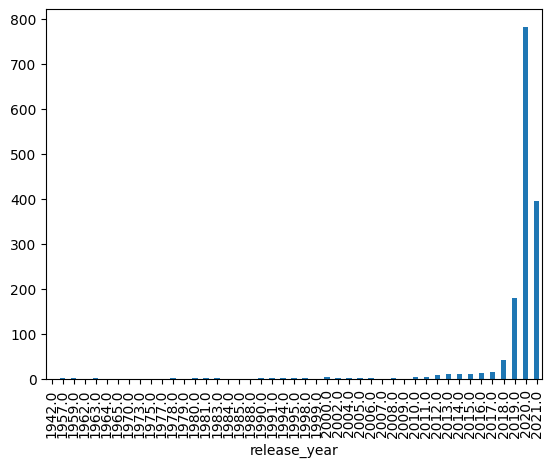

In [44]:
df_featdrop['release_year'].value_counts().sort_index().plot(kind='bar')


In [45]:
#“Are there specific years, months, or days that are overrepresented in the dataset — and if so, might a model learn to 'cheat' by using that frequency rather than the actual song characteristics?”

<Axes: title={'center': 'Releases per Year'}, xlabel='release_year'>

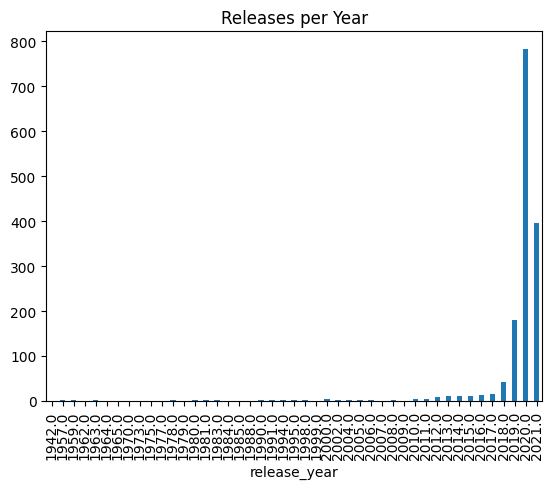

In [46]:
df_featdrop['release_year'].value_counts().sort_index().plot(kind='bar', title='Releases per Year')

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1556 entries, 0 to 1555
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Index                      1556 non-null   int64 
 1   Highest Charting Position  1556 non-null   int64 
 2   Number of Times Charted    1556 non-null   int64 
 3   Week of Highest Charting   1556 non-null   object
 4   Song Name                  1556 non-null   object
 5   Streams                    1556 non-null   object
 6   Artist                     1556 non-null   object
 7   Artist Followers           1556 non-null   object
 8   Song ID                    1556 non-null   object
 9   Genre                      1556 non-null   object
 10  Release Date               1556 non-null   object
 11  Weeks Charted              1556 non-null   object
 12  Popularity                 1556 non-null   object
 13  Danceability               1556 non-null   object
 14  Energy  

In [48]:
df_featdrop.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1545 entries, 0 to 1555
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Index              1545 non-null   int64         
 1   Song Name          1545 non-null   object        
 2   Artist             1545 non-null   object        
 3   Genre              1545 non-null   object        
 4   Release Date       1543 non-null   datetime64[ns]
 5   Danceability       1545 non-null   float64       
 6   Energy             1545 non-null   float64       
 7   Loudness           1545 non-null   float64       
 8   Speechiness        1545 non-null   float64       
 9   Acousticness       1545 non-null   float64       
 10  Liveness           1545 non-null   float64       
 11  Tempo              1545 non-null   float64       
 12  Duration (ms)      1545 non-null   float64       
 13  Valence            1545 non-null   float64       
 14  Key          

In [49]:
print(df.columns.tolist())

['Index', 'Highest Charting Position', 'Number of Times Charted', 'Week of Highest Charting', 'Song Name', 'Streams', 'Artist', 'Artist Followers', 'Song ID', 'Genre', 'Release Date', 'Weeks Charted', 'Popularity', 'Danceability', 'Energy', 'Loudness', 'Speechiness', 'Acousticness', 'Liveness', 'Tempo', 'Duration (ms)', 'Valence', 'Chord']


In [50]:
df.columns = df.columns.str.strip()  # remove trailing spaces

In [51]:
'Popularity' in df.columns

True

In [52]:
df['Popularity'].head()

,Popularity
0,100
1,99
2,99
3,98
4,96


In [53]:
df_featdrop_pop = df_featdrop.join(df['Popularity'])
df_featdrop_pop['Popularity'] = pd.to_numeric(df_featdrop_pop['Popularity'], errors='coerce')
df_featdrop_pop.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1545 entries, 0 to 1555
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Index              1545 non-null   int64         
 1   Song Name          1545 non-null   object        
 2   Artist             1545 non-null   object        
 3   Genre              1545 non-null   object        
 4   Release Date       1543 non-null   datetime64[ns]
 5   Danceability       1545 non-null   float64       
 6   Energy             1545 non-null   float64       
 7   Loudness           1545 non-null   float64       
 8   Speechiness        1545 non-null   float64       
 9   Acousticness       1545 non-null   float64       
 10  Liveness           1545 non-null   float64       
 11  Tempo              1545 non-null   float64       
 12  Duration (ms)      1545 non-null   float64       
 13  Valence            1545 non-null   float64       
 14  Key          

<Axes: title={'center': 'Avg Popularity by Year'}, xlabel='release_year'>

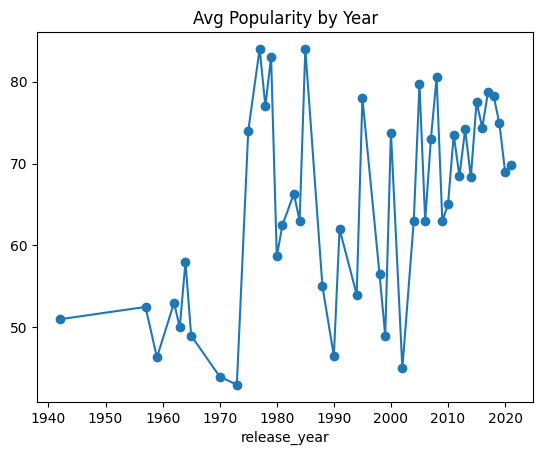

In [54]:
df_featdrop_pop.groupby('release_year')['Popularity'].mean().plot(marker='o', title='Avg Popularity by Year')

In [55]:
df_featdrop_pop[['release_year', 'Popularity']].corr()


,release_year,Popularity
release_year,1.000000,0.105829
Popularity,0.105829,1.000000


<Axes: title={'center': 'Releases per Month'}, xlabel='release_month'>

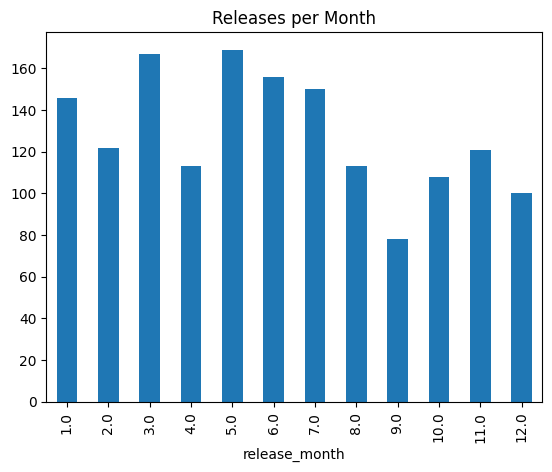

In [56]:
df_featdrop['release_month'] = df_featdrop['Release Date'].dt.month
df_featdrop['release_month'].value_counts().sort_index().plot(kind='bar', title='Releases per Month')


<Axes: title={'center': 'Avg Popularity by Month'}, xlabel='release_month'>

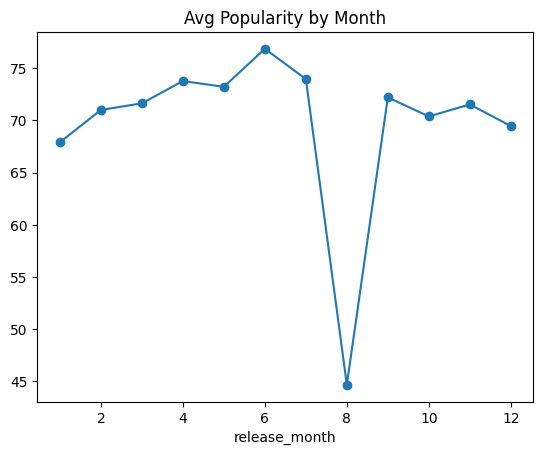

In [57]:
df_featdrop_pop.groupby('release_month')['Popularity'].mean().plot(marker='o', title='Avg Popularity by Month')

In [58]:
df_featdrop_pop[['release_month', 'Popularity']].corr()


,release_month,Popularity
release_month,1.000000,-0.061657
Popularity,-0.061657,1.000000


<Axes: title={'center': 'Releases per Day of Week'}, xlabel='release_day'>

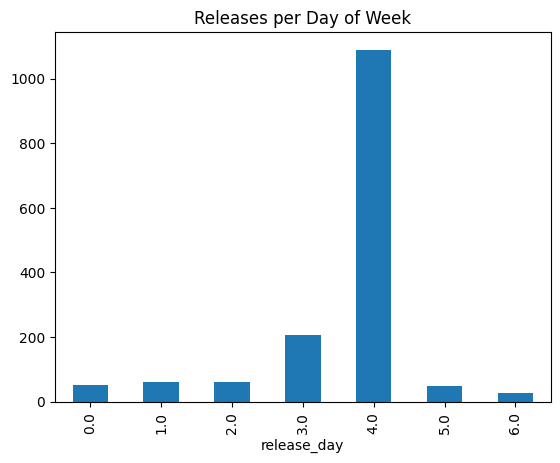

In [59]:
df_featdrop['release_day'] = df_featdrop['Release Date'].dt.dayofweek  # 0=Mon
df_featdrop['release_day'].value_counts().sort_index().plot(kind='bar', title='Releases per Day of Week')


<Axes: title={'center': 'Avg Popularity by Day of Week'}, xlabel='release_dayofweek'>

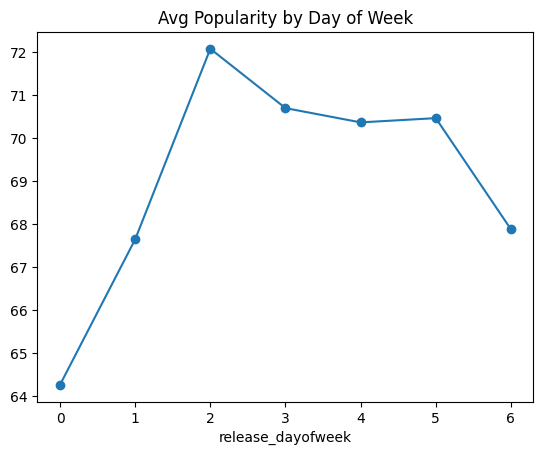

In [60]:
df_featdrop_pop.groupby('release_dayofweek')['Popularity'].mean().plot(marker='o', title='Avg Popularity by Day of Week')

In [61]:
df_featdrop_pop[['release_dayofweek', 'Popularity']].corr()


,release_dayofweek,Popularity
release_dayofweek,1.00000,0.04697
Popularity,0.04697,1.00000


In [62]:
df_numeric_corr = df_featdrop.select_dtypes(include='number').corr()
df_numeric_corr

,Index,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,Key,release_year,release_month,release_dayofweek,release_day
Index,1.000000,0.126254,-0.018813,-0.014321,0.109213,-0.063914,0.028976,0.023622,-0.023481,-0.054632,0.005330,0.041803,-0.136472,0.097373,0.097373
Danceability,0.126254,1.000000,0.142130,0.234928,0.237394,-0.316798,-0.114518,-0.040219,-0.101390,0.361627,0.100914,0.178776,-0.030753,0.050142,0.050142
Energy,-0.018813,0.142130,1.000000,0.732616,0.023989,-0.542399,0.124693,0.113352,0.056624,0.356325,0.067341,0.094094,0.003645,-0.035077,-0.035077
Loudness,-0.014321,0.234928,0.732616,1.000000,-0.018823,-0.477431,0.043141,0.104371,0.075262,0.298762,0.028428,0.228810,0.012514,-0.016828,-0.016828
Speechiness,0.109213,0.237394,0.023989,-0.018823,1.000000,-0.131436,0.072774,0.111255,-0.089895,0.038032,0.036028,0.134638,-0.049146,0.059094,0.059094
Acousticness,-0.063914,-0.316798,-0.542399,-0.477431,-0.131436,1.000000,-0.005469,-0.061632,-0.046010,-0.096997,-0.047796,-0.140518,0.041450,-0.045257,-0.045257
Liveness,0.028976,-0.114518,0.124693,0.043141,0.072774,-0.005469,1.000000,-0.018265,0.019685,0.007882,-0.003376,-0.060855,0.005900,-0.003431,-0.003431
Tempo,0.023622,-0.040219,0.113352,0.104371,0.111255,-0.061632,-0.018265,1.000000,-0.004671,0.057563,-0.016705,0.011346,0.034022,-0.007277,-0.007277
Duration (ms),-0.023481,-0.101390,0.056624,0.075262,-0.089895,-0.046010,0.019685,-0.004671,1.000000,-0.119981,-0.041157,-0.031029,-0.022832,0.005914,0.005914
Valence,-0.054632,0.361627,0.356325,0.298762,0.038032,-0.096997,0.007882,0.057563,-0.119981,1.000000,0.057431,-0.091691,0.025446,-0.061601,-0.061601


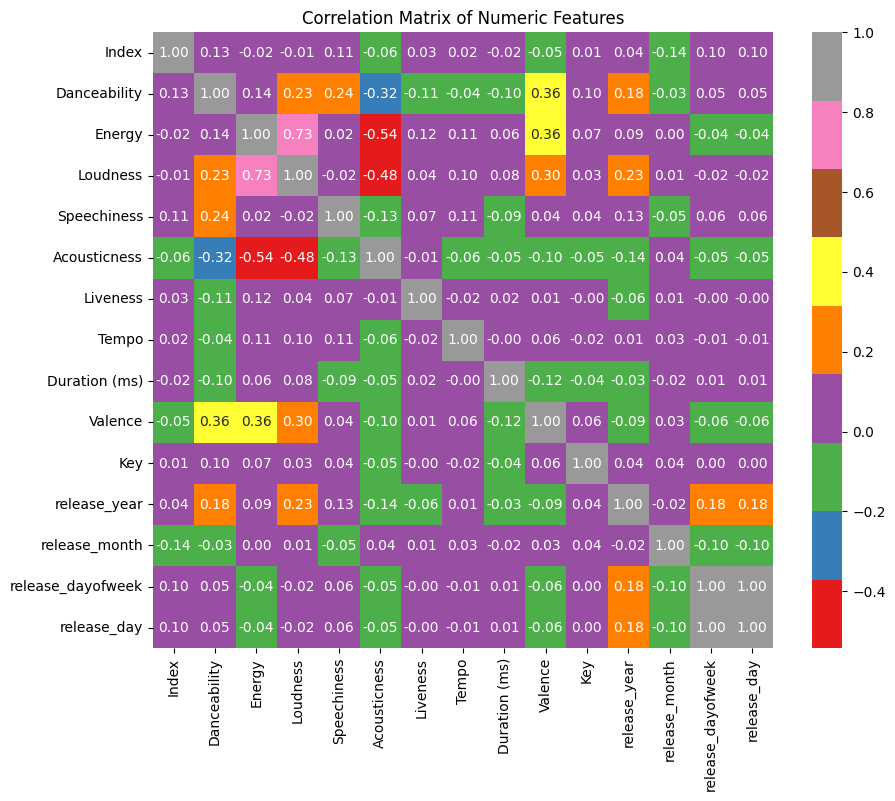

In [63]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_numeric_corr, annot=True, fmt=".2f", cmap="Set1")
plt.title("Correlation Matrix of Numeric Features")
plt.show()

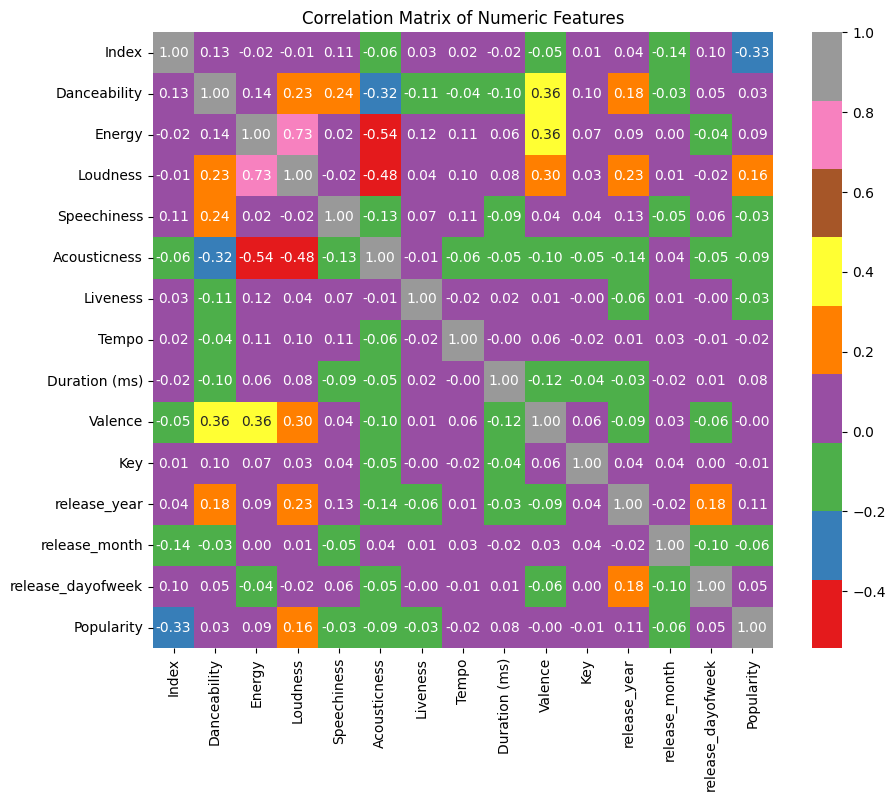

In [64]:
df_numeric_corr_pop = df_featdrop_pop.select_dtypes(include='number').corr()
plt.figure(figsize=(10, 8))
sns.heatmap(df_numeric_corr_pop, annot=True, fmt=".2f", cmap="Set1")
plt.title("Correlation Matrix of Numeric Features")
plt.show()

##Data Processing

###Feature Selection

In [65]:
pop_list

['Highest Charting Position',
 'Number of Times Charted',
 'Week of Highest Charting',
 'Streams',
 'Artist Followers',
 'Weeks Charted',
 'Popularity']

In [66]:
prerelease_list

['Streams', 'Artist Followers', 'Popularity']

In [67]:
postrelease_list

['Highest Charting Position',
 'Number of Times Charted',
 'Week of Highest Charting',
 'Weeks Charted']

In [68]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1556 entries, 0 to 1555
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Index                      1556 non-null   int64 
 1   Highest Charting Position  1556 non-null   int64 
 2   Number of Times Charted    1556 non-null   int64 
 3   Week of Highest Charting   1556 non-null   object
 4   Song Name                  1556 non-null   object
 5   Streams                    1556 non-null   object
 6   Artist                     1556 non-null   object
 7   Artist Followers           1556 non-null   object
 8   Song ID                    1556 non-null   object
 9   Genre                      1556 non-null   object
 10  Release Date               1556 non-null   object
 11  Weeks Charted              1556 non-null   object
 12  Popularity                 1556 non-null   object
 13  Danceability               1556 non-null   object
 14  Energy  

In [69]:
df_featdrop.head(10)

,Index,Song Name,Artist,Genre,Release Date,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,Key,release_year,release_month,release_dayofweek,release_ym,release_day
0,1,Beggin',Måneskin,"['indie rock italiano', 'italian pop']",2017-12-08,0.714,0.800,-4.808,0.0504,0.12700,0.3590,134.002,211560.0,0.589,11,2017.0,12.0,4.0,2017-12,4.0
1,2,STAY (with Justin Bieber),The Kid LAROI,['australian hip hop'],2021-07-09,0.591,0.764,-5.484,0.0483,0.03830,0.1030,169.928,141806.0,0.478,1,2021.0,7.0,4.0,2021-07,4.0
2,3,good 4 u,Olivia Rodrigo,['pop'],2021-05-21,0.563,0.664,-5.044,0.1540,0.33500,0.0849,166.928,178147.0,0.688,9,2021.0,5.0,4.0,2021-05,4.0
3,4,Bad Habits,Ed Sheeran,"['pop', 'uk pop']",2021-06-25,0.808,0.897,-3.712,0.0348,0.04690,0.3640,126.026,231041.0,0.591,11,2021.0,6.0,4.0,2021-06,4.0
4,5,INDUSTRY BABY (feat. Jack Harlow),Lil Nas X,"['lgbtq+ hip hop', 'pop rap']",2021-07-23,0.736,0.704,-7.409,0.0615,0.02030,0.0501,149.995,212000.0,0.894,3,2021.0,7.0,4.0,2021-07,4.0
5,6,MONTERO (Call Me By Your Name),Lil Nas X,"['lgbtq+ hip hop', 'pop rap']",2021-03-31,0.610,0.508,-6.682,0.1520,0.29700,0.3840,178.818,137876.0,0.758,8,2021.0,3.0,2.0,2021-03,2.0
6,7,Kiss Me More (feat. SZA),Doja Cat,"['dance pop', 'pop']",2021-04-09,0.762,0.701,-3.541,0.0286,0.23500,0.1230,110.968,208867.0,0.742,8,2021.0,4.0,4.0,2021-04,4.0
7,8,Todo De Ti,Rauw Alejandro,"['puerto rican pop', 'trap latino']",2021-05-20,0.780,0.718,-3.605,0.0506,0.31000,0.0932,127.949,199604.0,0.342,3,2021.0,5.0,3.0,2021-05,3.0
8,9,Yonaguni,Bad Bunny,"['latin', 'reggaeton', 'trap latino']",2021-06-04,0.644,0.648,-4.601,0.1180,0.27600,0.1350,179.951,206710.0,0.440,1,2021.0,6.0,4.0,2021-06,4.0
9,10,I WANNA BE YOUR SLAVE,Måneskin,"['indie rock italiano', 'italian pop']",2021-03-19,0.750,0.608,-4.008,0.0387,0.00165,0.1780,132.507,173347.0,0.958,1,2021.0,3.0,4.0,2021-03,4.0


In [70]:
df_featdrop.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1545 entries, 0 to 1555
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Index              1545 non-null   int64         
 1   Song Name          1545 non-null   object        
 2   Artist             1545 non-null   object        
 3   Genre              1545 non-null   object        
 4   Release Date       1543 non-null   datetime64[ns]
 5   Danceability       1545 non-null   float64       
 6   Energy             1545 non-null   float64       
 7   Loudness           1545 non-null   float64       
 8   Speechiness        1545 non-null   float64       
 9   Acousticness       1545 non-null   float64       
 10  Liveness           1545 non-null   float64       
 11  Tempo              1545 non-null   float64       
 12  Duration (ms)      1545 non-null   float64       
 13  Valence            1545 non-null   float64       
 14  Key          

In [71]:
#ChatGPT helping me break Genre into binaries
#'Genre' is a stringified list, so let's convert it
df_featdrop['Genre'] = df_featdrop['Genre'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

In [72]:
#MultiLabelBinarizer for one-hot-encoding converted 'Genre'
mlb = MultiLabelBinarizer()
genre_dummies = pd.DataFrame(
    mlb.fit_transform(df_featdrop['Genre']),
    columns=mlb.classes_,
    index=df_featdrop.index
)

In [73]:
df_featdrop_genre = pd.concat([df_featdrop, genre_dummies], axis=1)

In [74]:
df_featdrop_genre.head(20)

,Index,Song Name,Artist,Genre,Release Date,Danceability,Energy,Loudness,Speechiness,Acousticness,...,vancouver indie,vapor trap,vegas indie,venezuelan hip hop,viral pop,viral rap,vocal jazz,weirdcore,west coast rap,yacht rock
0,1,Beggin',Måneskin,"[indie rock italiano, italian pop]",2017-12-08,0.714,0.800,-4.808,0.0504,0.12700,...,0,0,0,0,0,0,0,0,0,0
1,2,STAY (with Justin Bieber),The Kid LAROI,[australian hip hop],2021-07-09,0.591,0.764,-5.484,0.0483,0.03830,...,0,0,0,0,0,0,0,0,0,0
2,3,good 4 u,Olivia Rodrigo,[pop],2021-05-21,0.563,0.664,-5.044,0.1540,0.33500,...,0,0,0,0,0,0,0,0,0,0
3,4,Bad Habits,Ed Sheeran,"[pop, uk pop]",2021-06-25,0.808,0.897,-3.712,0.0348,0.04690,...,0,0,0,0,0,0,0,0,0,0
4,5,INDUSTRY BABY (feat. Jack Harlow),Lil Nas X,"[lgbtq+ hip hop, pop rap]",2021-07-23,0.736,0.704,-7.409,0.0615,0.02030,...,0,0,0,0,0,0,0,0,0,0
5,6,MONTERO (Call Me By Your Name),Lil Nas X,"[lgbtq+ hip hop, pop rap]",2021-03-31,0.610,0.508,-6.682,0.1520,0.29700,...,0,0,0,0,0,0,0,0,0,0
6,7,Kiss Me More (feat. SZA),Doja Cat,"[dance pop, pop]",2021-04-09,0.762,0.701,-3.541,0.0286,0.23500,...,0,0,0,0,0,0,0,0,0,0
7,8,Todo De Ti,Rauw Alejandro,"[puerto rican pop, trap latino]",2021-05-20,0.780,0.718,-3.605,0.0506,0.31000,...,0,0,0,0,0,0,0,0,0,0
8,9,Yonaguni,Bad Bunny,"[latin, reggaeton, trap latino]",2021-06-04,0.644,0.648,-4.601,0.1180,0.27600,...,0,0,0,0,0,0,0,0,0,0
9,10,I WANNA BE YOUR SLAVE,Måneskin,"[indie rock italiano, italian pop]",2021-03-19,0.750,0.608,-4.008,0.0387,0.00165,...,0,0,0,0,0,0,0,0,0,0


In [75]:
#simplify the dataframe to remove non-numerics (fast track process; revisit later)
next_drop = ['Song Name', 'Artist', 'Genre', 'Release Date', 'release_ym']
df_feat_s = df_featdrop_genre.drop(columns = next_drop)
df_feat_s.shape

(1545, 349)

In [76]:
df_feat_s.isna().sum().sum()

np.int64(8)

In [77]:
#Drop all rows with na (fast mode processing; can refine later)
df_feat_s_clean = df_feat_s.dropna()

In [78]:
df_feat_s_clean.isna().sum().sum()

np.int64(0)

In [79]:
df_feat_s_clean.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 1543 entries, 0 to 1555
Data columns (total 349 columns):
 #    Column                      Dtype  
---   ------                      -----  
 0    Index                       int64  
 1    Danceability                float64
 2    Energy                      float64
 3    Loudness                    float64
 4    Speechiness                 float64
 5    Acousticness                float64
 6    Liveness                    float64
 7    Tempo                       float64
 8    Duration (ms)               float64
 9    Valence                     float64
 10   Key                         Int64  
 11   release_year                float64
 12   release_month               float64
 13   release_dayofweek           float64
 14   release_day                 float64
 15   a cappella                  int64  
 16   acoustic pop                int64  
 17   adult standards             int64  
 18   afrofuturism                int64  
 19   afroswing

In [80]:
#Df for each target

#Popularity Target
df_target_pop = df_feat_s_clean.join(df_copy['Popularity'])
df_target_pop = pd.to_numeric(df_target_pop['Popularity'], errors='coerce')

#Highest Charting Position Target
df_target_hcp = df_feat_s_clean.join(df_copy['Highest Charting Position'])
df_target_hcp = pd.to_numeric(df_target_hcp['Highest Charting Position'], errors='coerce')

#Number of Times Charted Target
df_target_ntc = df_feat_s_clean.join(df_copy['Number of Times Charted'])
df_target_ntc = pd.to_numeric(df_target_ntc['Number of Times Charted'], errors='coerce')

In [81]:
df_target_pop.describe()

,Popularity
count,1543.000000
mean,70.132210
std,15.789287
min,0.000000
25%,65.000000
50%,73.000000
75%,80.000000
max,100.000000


In [82]:
df_target_hcp.describe()

,Highest Charting Position
count,1543.000000
mean,87.734284
std,58.114723
min,1.000000
25%,37.000000
50%,80.000000
75%,136.500000
max,200.000000


In [83]:
df_target_ntc.describe()

,Number of Times Charted
count,1543.000000
mean,10.696695
std,16.396673
min,1.000000
25%,1.000000
50%,4.000000
75%,12.000000
max,142.000000


In [84]:
df_feat_s_clean_copy = df_feat_s_clean.copy()

#There is a strong predictive capability using the Index... so we are going to avoid relying on that
df_feat_s_clean = df_feat_s_clean.drop(columns = 'Index')

In [85]:
# Split train & test
features = df_feat_s_clean
target = df_target_pop
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape)

(1234, 348) (309, 348)


RMSE: 9.157163071590618
             Feature  Importance
10      release_year    0.819452
11     release_month    0.063634
16   adult standards    0.019926
137   german hip hop    0.014484
177            k-pop    0.012186
5           Liveness    0.009384
255    post-teen pop    0.008441
13       release_day    0.008367
51    brooklyn drill    0.008101
152          hip pop    0.007915


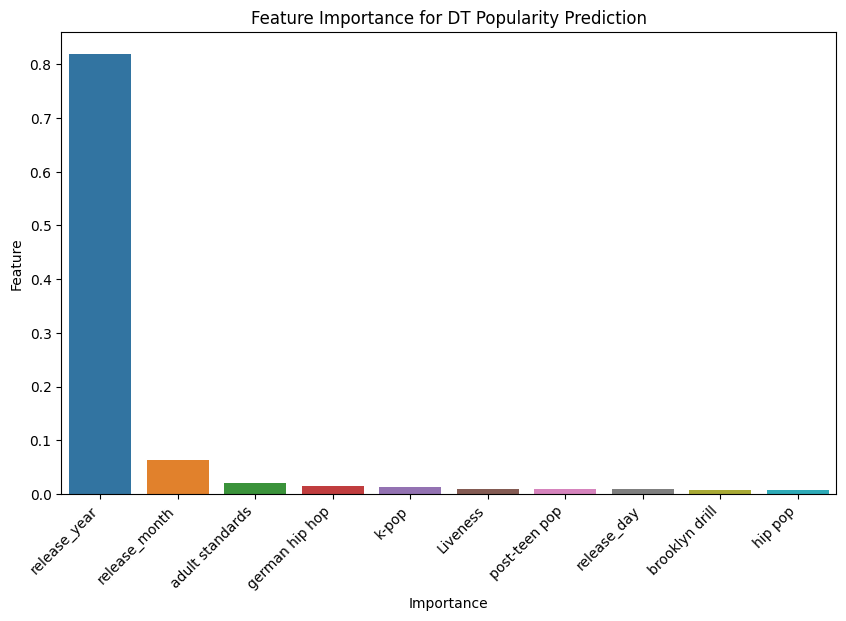

In [86]:
##Thanks to Minerva for the visualization approach inspiration
# Single Train-Test Split

# Define predictors and target variable
predictors_2 = features
target_2 = target

X = predictors_2
y = target_2

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train decision tree regressor
tree_model = DecisionTreeRegressor(max_depth=5, random_state=42)
tree_model.fit(X_train, y_train)

# Predict and evaluate model
y_pred = tree_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)

# Calculate feature importance
importance = tree_model.feature_importances_

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importance})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

feature_imp10 = feature_importance_df.head(10)

# Display feature importance
print(feature_imp10)

# Plot feature importance
plt.figure(figsize=(10, 6))
number_features = len(feature_imp10)
colors = list(cm.rainbow(np.linspace(0, 1, number_features)))
sns.barplot(x='Feature', y='Importance', hue = 'Feature', data=feature_imp10)#to print vertically
plt.title('Feature Importance for DT Popularity Prediction')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels to 45 degrees
plt.show()

In [87]:
max_depths = [1,2,3,4,5,6,7,8,9,10]
rms_depth = np.zeros(len(max_depths))
std_depth = np.zeros(len(max_depths))

numLoops = 500

for n, depth in enumerate(max_depths):
  rms_error = np.zeros(numLoops)

  for idx in range(0,numLoops):
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
    model = DecisionTreeRegressor(max_depth=depth)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    rms_error[idx] = np.sqrt(mean_squared_error(y_test, y_pred))

  rms_depth[n] = rms_error.mean()
  std_depth[n] = rms_error.std( ddof = 1 )

In [88]:
pd.DataFrame( zip( max_depths, rms_depth, std_depth ) )

,0,1,2
0,1,15.471362,1.174585
1,2,10.091647,1.879561
2,3,9.482641,0.462745
3,4,9.221249,0.529969
4,5,9.153225,0.578061
5,6,9.156416,0.543708
6,7,9.231929,0.572927
7,8,9.346870,0.625297
8,9,9.487433,0.610689
9,10,9.624309,0.613371


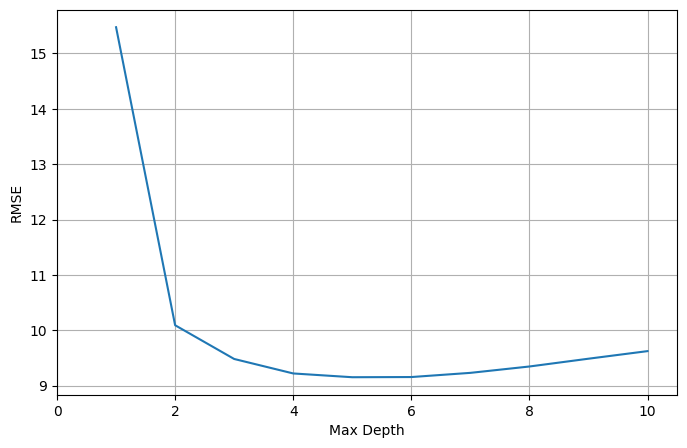

In [89]:
# Plot result
plt.figure(figsize = (8,5))
plt.plot(max_depths, rms_depth)
plt.xlabel('Max Depth')
plt.ylabel('RMSE')
plt.xlim(0, 10.5)
plt.grid()

In [90]:
# Re run with max depth = 5
numLoops = 500

rms_error = np.zeros( numLoops )

for idx in range( 0, numLoops ):
  X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2 )
  model = DecisionTreeRegressor( max_depth=5 )
  model.fit( X_train, y_train )
  y_pred = model.predict( X_test )
  rms_error[idx] = np.sqrt( mean_squared_error( y_test, y_pred ) )

print(f"CV RMSE: {rms_error.mean().round(2)}")


CV RMSE: 9.11


In [91]:
#Calculate feature importance
importance = model.feature_importances_
importance

array([7.03455427e-04, 0.00000000e+00, 4.98156722e-05, 4.56904343e-03,
       5.77515195e-03, 2.38607754e-06, 0.00000000e+00, 1.71374436e-05,
       6.68232643e-03, 0.00000000e+00, 8.11303980e-01, 6.07509562e-02,
       9.20644726e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       3.16076236e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 8.34936253e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [92]:
X.columns

Index(['Danceability', 'Energy', 'Loudness', 'Speechiness', 'Acousticness',
       'Liveness', 'Tempo', 'Duration (ms)', 'Valence', 'Key',
       ...
       'vancouver indie', 'vapor trap', 'vegas indie', 'venezuelan hip hop',
       'viral pop', 'viral rap', 'vocal jazz', 'weirdcore', 'west coast rap',
       'yacht rock'],
      dtype='object', length=348)

In [93]:
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importance})
feature_importance.sort_values(by = "Importance", ascending=False)

,Feature,Importance
10,release_year,0.811304
11,release_month,0.060751
16,adult standards,0.031608
177,k-pop,0.013336
137,german hip hop,0.013279
...,...,...
118,folktronica,0.000000
117,folk-pop,0.000000
116,folk rock,0.000000
115,folk punk,0.000000


               Feature  Importance
10        release_year    0.811304
11       release_month    0.060751
16     adult standards    0.031608
177              k-pop    0.013336
137     german hip hop    0.013279
188             lounge    0.012724
12   release_dayofweek    0.009206
206         moombahton    0.009099
51      brooklyn drill    0.008349
8              Valence    0.006682


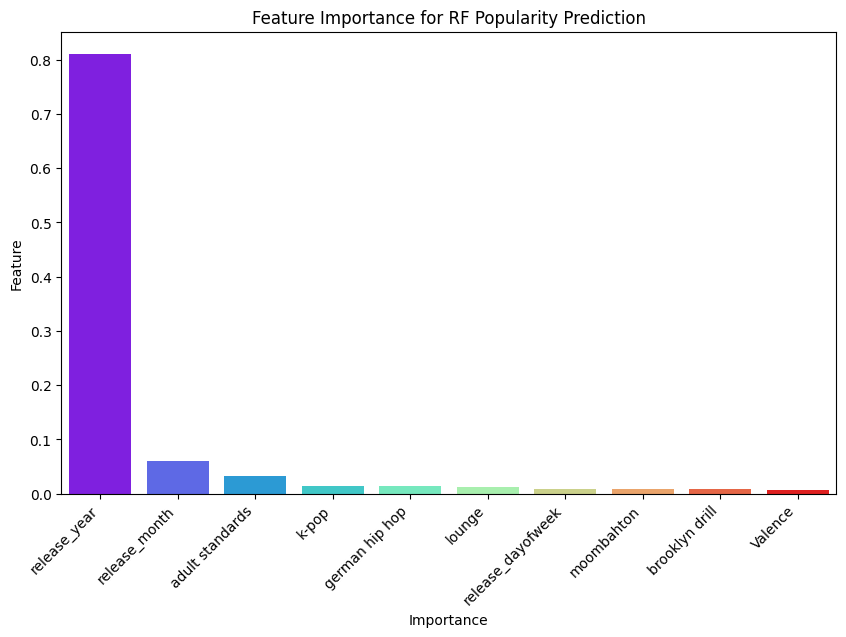

In [94]:
# Sort by importance
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

feat_imp10 = feature_importance.head(10)

# Display feature importance
print(feat_imp10)

# Plot feature importance with rainbow colors
plt.figure(figsize=(10, 6))
num_features = len(feat_imp10)
colors = list(cm.rainbow(np.linspace(0, 1, num_features)))  # Convert to list
sns.barplot(x='Feature', y='Importance', data=feat_imp10, hue='Feature', palette=colors, dodge=False, legend=False)  # Apply rainbow colors, assign hue and set legend=False
plt.title('Feature Importance for RF Popularity Prediction')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.xticks(rotation=45, ha='right')
plt.show()


###Random Forest

In [95]:
# two parameters - n_estimators (number of trees), max_depth (number of splits)
numLoops = 100

mean_error = np.zeros(numLoops)

# np.random.seed(42)
for idx in range(0,numLoops):
  X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.2 )
  model = RandomForestRegressor( n_estimators = 10 ) #n_estimators is number of trees in forest. Note: you can also choose max_depth for RFs
  model.fit( X_train, y_train )
  y_pred = model.predict( X_test )
  mean_error[idx] = mean_squared_error( y_test, y_pred )

print(f'RMSE: {np.sqrt(mean_error).mean()}')
print(f'RMSE_std: {np.sqrt(mean_error).std()}')
np.sqrt(mean_error)[:50]


RMSE: 8.758713171916492
RMSE_std: 0.568618560409498


array([ 8.31540272,  8.6986403 ,  7.6533048 ,  8.12869184,  8.24610725,
        9.56948359,  8.51659526,  8.75858709,  8.29764656,  8.53161454,
        8.99085476,  9.51347027,  8.4910099 ,  8.50016562,  9.14974667,
        9.05309044,  9.01207389, 10.06476921,  9.44531185,  7.83852613,
        8.5750013 ,  8.73187258,  9.27688431,  8.77700364,  9.15535283,
        8.70733983,  8.70912924,  8.01476388,  8.45645423,  7.7684221 ,
       10.27904363,  8.6548488 ,  9.87899114,  8.02505583,  9.34934883,
        9.26678832,  8.885913  ,  8.31864207,  9.6146093 ,  8.4191164 ,
        8.91979182,  8.46112947,  9.22095545,  8.7306346 ,  8.97721135,
        9.08457742,  8.06927129,  8.03014748,  9.04921281,  8.83829927])

In [96]:
num_trees = range(10,60,10)
cv_loops = 100
rmse_results = np.zeros(len(num_trees))
std_results = np.zeros(len(num_trees))

for n, trees in enumerate(num_trees):
  rmse_cv = np.zeros(cv_loops)
  np.random.seed(42)
  for i in range(cv_loops):
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20)
    rfModel = RandomForestRegressor( n_estimators=trees )
    rfModel.fit(X_train, y_train)
    y_pred_rf = rfModel.predict(X_test)
    rmse_cv[i] = np.sqrt(mean_squared_error(y_test, y_pred_rf))

  print(trees,' trees finished.')
  rmse_results[n] = rmse_cv.mean()
  std_results[n] = rmse_cv.std()


10  trees finished.
20  trees finished.
30  trees finished.
40  trees finished.
50  trees finished.


In [97]:
pickle.dump(rfModel, open('rfModel.p','wb'))


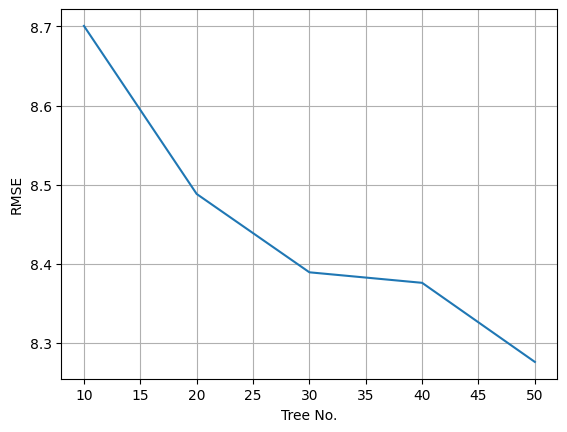

In [98]:
plt.plot(num_trees, rmse_results)
plt.xlabel('Tree No.')
plt.ylabel('RMSE')
plt.grid()


In [99]:
pd.DataFrame( zip( rmse_results, std_results, ) )


,0,1
0,8.700705,0.545966
1,8.488318,0.479407
2,8.389278,0.453554
3,8.375979,0.497965
4,8.275999,0.471125


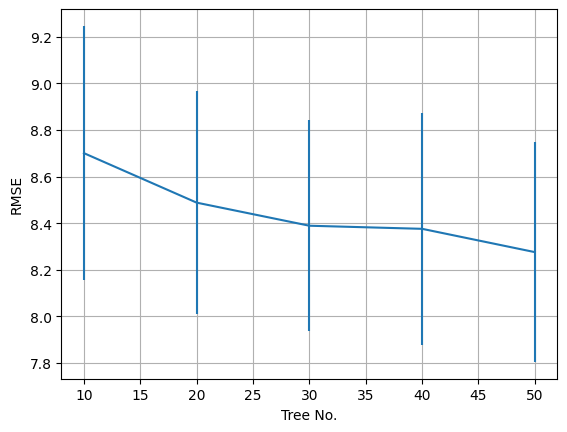

In [100]:
# plt.errorbar(num_trees, rmse_results, yerr=(std_results*2,std_results*2))
plt.errorbar(num_trees, rmse_results, yerr=std_results)
plt.xlabel('Tree No.')
plt.ylabel('RMSE')
plt.grid()


In [101]:
print(f'RMSE with 50 trees: {rmse_results[4]}')

RMSE with 50 trees: 8.275999442478685


###XGBoost

In [102]:
numLoops = 100
mse_xgb  = np.zeros(numLoops)

for idx in range(0,numLoops):
  X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15)
  xgbr = xgb.XGBRegressor(objective ='reg:squarederror', verbosity=0, seed = 10)
  xgbr.fit(X_train,y_train)
  y_pred_xgb = xgbr.predict(X_test)
  mse_xgb[idx] = mean_squared_error(y_test,y_pred_xgb)

print(f'RMSE: {np.sqrt(mse_xgb).mean()}')


RMSE: 8.489996353373087


In [103]:
y_pred_xgb[0]


np.float32(64.25705)

In [104]:
y_test.to_numpy()[0]


np.int64(62)

In [105]:
my_spot = X_test[:3]
my_spot


,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,Key,...,vancouver indie,vapor trap,vegas indie,venezuelan hip hop,viral pop,viral rap,vocal jazz,weirdcore,west coast rap,yacht rock
1404,0.764,0.443,-6.625,0.0439,0.5200,0.0749,138.999,168200.0,0.6300,4,...,0,0,0,0,0,0,0,0,0,0
372,0.631,0.239,-7.071,0.0398,0.8640,0.1160,79.859,149297.0,0.0927,11,...,0,0,0,0,0,0,0,0,0,0
1417,0.576,0.807,-3.019,0.0374,0.0185,0.0963,90.932,192737.0,0.4790,7,...,0,0,0,0,0,0,0,0,0,0


In [106]:
y_test[:3]


,Popularity
1404,62
372,80
1417,62


In [107]:
# Specify the parameters you want to try and their ranges.
param_test = {
 'max_depth'     : [ 3, 4, 5, 6, 7 ],
 'learning_rate' : [ 0.1, 0.2, 0.3, 0.4 ],
 'n_estimators'  : [ 20, 40, 60, 80, 100, 120, 140 ],
}

# Perform the grid search
gsearch = GridSearchCV(
    estimator = xgb.XGBRegressor( objective = 'reg:squarederror', seed = 10 ),
    param_grid = param_test,
    scoring = 'neg_mean_squared_error',
    cv = 5,
)

# Fit to training data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.05, random_state = 42 )
model = gsearch.fit(X_train,y_train)

# See grid search results
print(model.best_params_)


{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 140}


In [108]:
params = model.best_params_

numLoops = 100
mse_xgb  = np.zeros(numLoops)

for idx in range(0,numLoops):
  X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.15 )
  xgbr = xgb.XGBRegressor(
      objective ='reg:squarederror',
      verbosity=0,
      # **params,
      learning_rate = 0.1,
      max_depth = 4,
      n_estimators = 140,
      seed = 10,
  )
  xgbr.fit(X_train,y_train)
  y_pred_xgb = xgbr.predict(X_test)
  mse_xgb[idx] = mean_squared_error(y_test,y_pred_xgb)

print(f'RMSE: {np.sqrt(mse_xgb).mean()}')


RMSE: 8.317837660605239


/tmp/ipython-input-1571230868.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels( ax.get_xticklabels(), rotation = 90 )


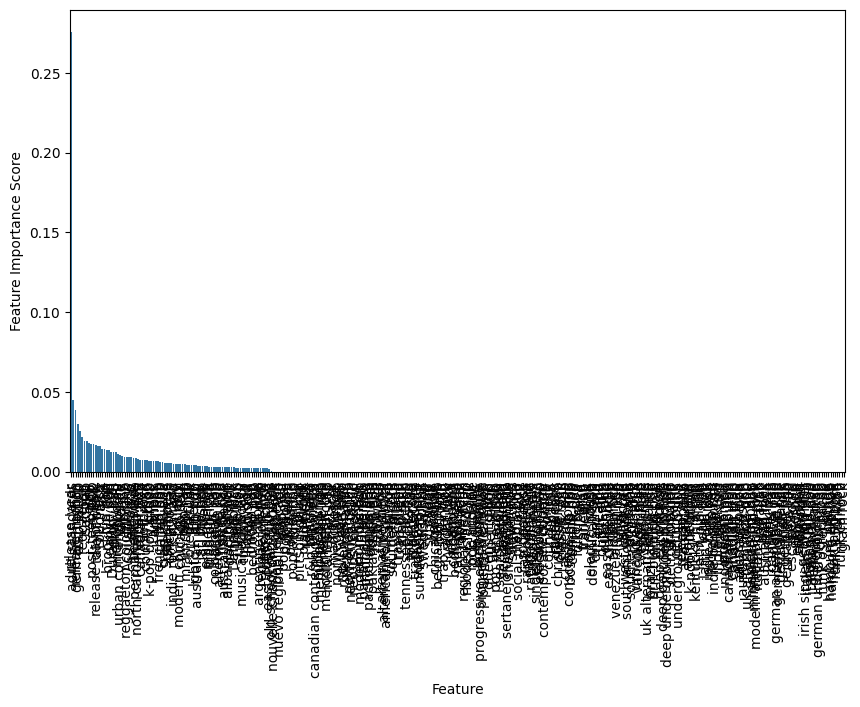

In [109]:
feat_imp = pd.Series(xgbr.feature_importances_, index=X.columns).sort_values( ascending = False )
plt.figure(figsize = (10,6))
ax = sns.barplot(x = feat_imp.index, y = feat_imp.values )
ax.set_xticklabels( ax.get_xticklabels(), rotation = 90 )
plt.xlabel('Feature')
plt.ylabel('Feature Importance Score') ;


In [110]:
(feat_imp.sort_values( ascending = False )).cumsum().head(20)


,0
release_year,0.275755
adult standards,0.320635
release_month,0.359179
german hip hop,0.388844
trap latino,0.414443
reggaeton,0.436406
pop,0.455659
sad rap,0.474886
edm,0.492858
k-pop,0.510258


##Visualization

In [111]:
df_feat_s_clean.shape

(1543, 348)

In [112]:
df_notgenres = ['Danceability',
    'Energy',
    'Loudness',
    'Speechiness',
    'Acousticness',
    'Liveness',
    'Tempo',
    'Duration (ms)',
    'Valence',
    'Key',
    'release_year',
    'release_month',
    'release_dayofweek',
    'release_day']

In [113]:
df_genres = df_feat_s_clean.drop(columns = df_notgenres)
df_genres.shape

(1543, 334)

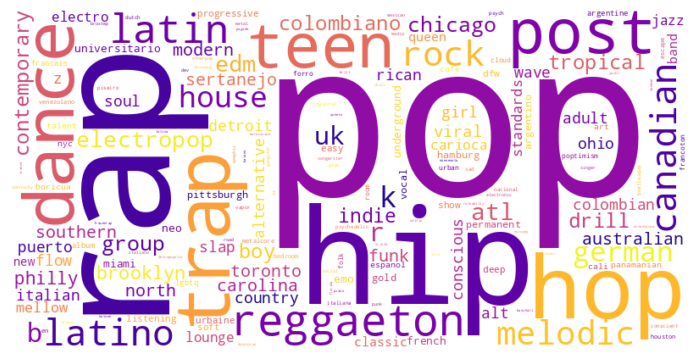

In [114]:
#Let's try a wordcloud (thanks to ChatGPT for the help)

# --- Step 1: Sum across one-hot genre columns to get total counts ---
genre_counts = df_genres.sum().sort_values(ascending=False)

# --- Step 2: Generate word cloud from original genre labels ---
wordcloud_basic = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(genre_counts.to_dict())

# --- Step 3: Decompose multi-concept genres (e.g., "indie rock", "k-pop") ---
decomposed_counts = Counter()

for genre, count in genre_counts.items():
    # Split on non-letters (space, dash, slash, etc.)
    parts = re.split(r'[^a-zA-Z]+', genre.lower())
    for part in parts:
        if part:  # Avoid empty strings
            decomposed_counts[part] += count

# --- Step 4: Generate word cloud from decomposed genre parts ---
wordcloud_decomposed = WordCloud(width=800, height=400, background_color='white', colormap='plasma').generate_from_frequencies(decomposed_counts)

# --- Step 5: Plot both side by side ---
plt.figure(figsize=(14, 6))

# plt.subplot(1, 2, 1)
# plt.imshow(wordcloud_basic, interpolation='bilinear')
# plt.axis('off')
# plt.title("Word Cloud: Original Genre Labels")

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_decomposed, interpolation='bilinear')
plt.axis('off')
# plt.title("Word Cloud: Decomposed Genre Parts")

plt.tight_layout()
plt.show()

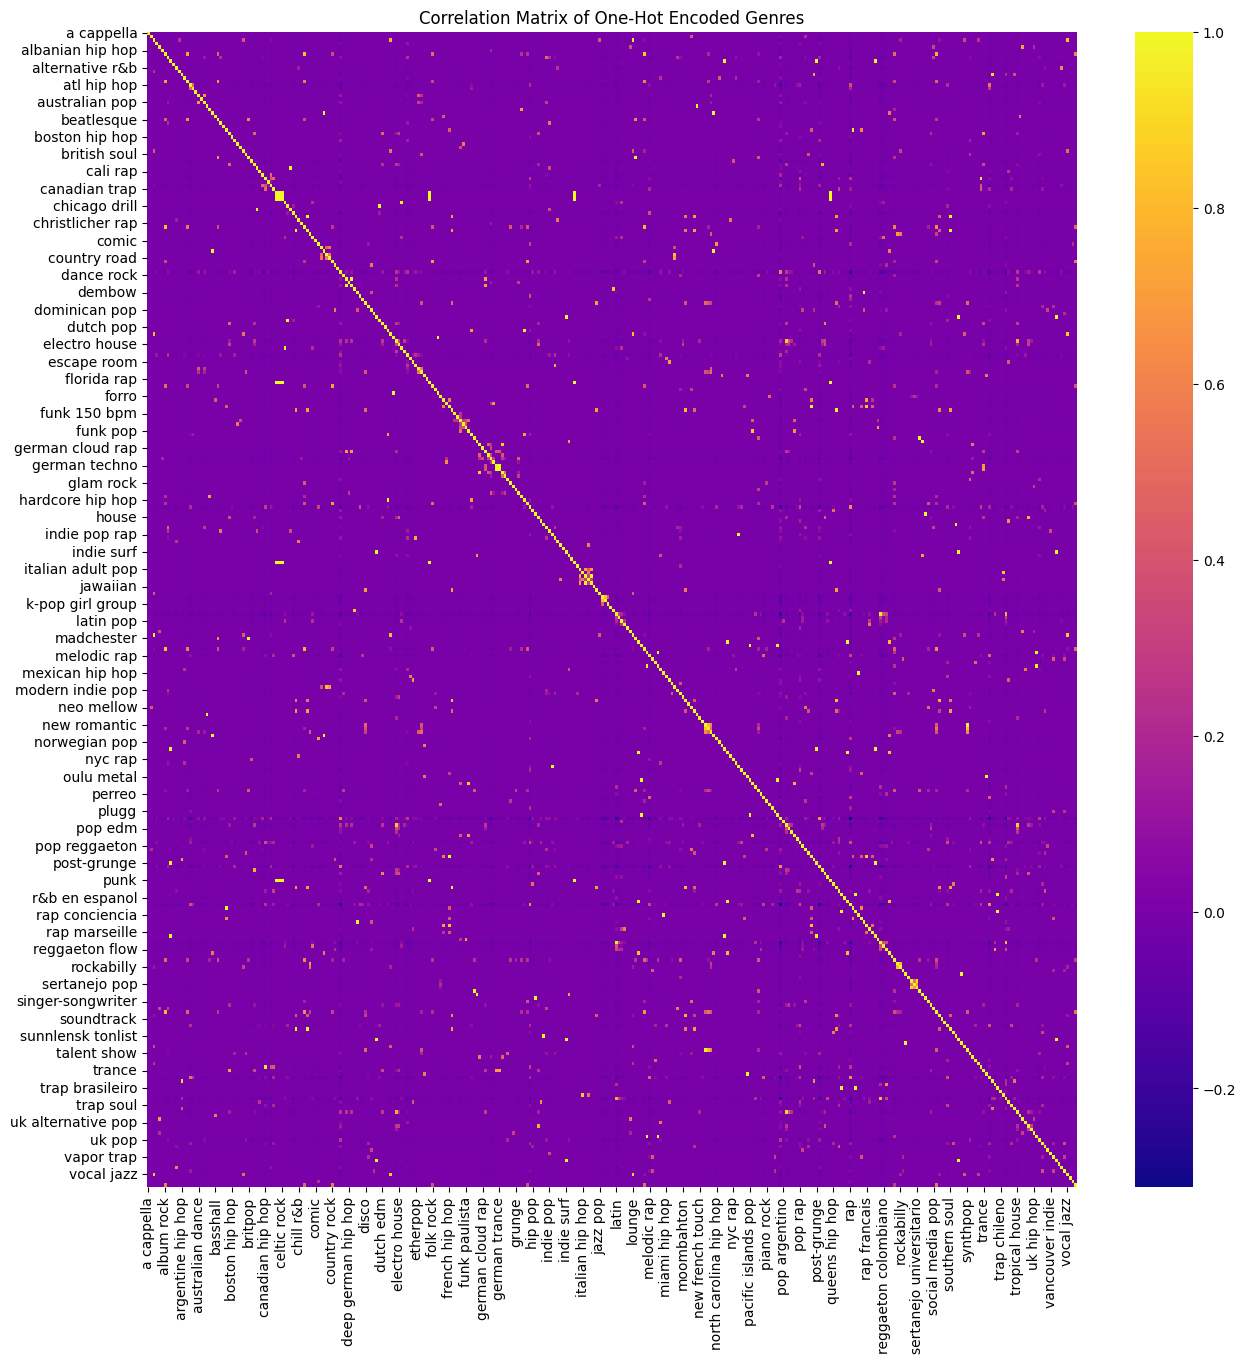

In [115]:
df_genres_corr = df_genres.corr()
plt.figure(figsize=(15, 15))
sns.heatmap(df_genres_corr, annot=False, cmap="plasma")
plt.title("Correlation Matrix of One-Hot Encoded Genres")
plt.show()